In [2]:
from web3 import Web3
from eth_defi.provider.multi_provider import create_multi_provider_web3
from eth_defi.gmx.config import GMXConfig
from eth_defi.gmx.data import GMXMarketData
import pandas as pd
import matplotlib.pyplot as plt
import os

json_rpc_url = os.environ.get("JSON_RPC_ETHEREUM")
if not json_rpc_url:
    json_rpc_url = input("Please enter your Ethereum mainnet JSON-RPC URL here: ")
web3 = create_multi_provider_web3(json_rpc_url)

# Create GMX configuration
config = GMXConfig(web3)

# Initialize market data provider
market_data = GMXMarketData(config)

# Get open interest data - this is the key line!
open_interest = market_data.get_open_interest()

print("Open Interest retrieved successfully!")
print(f"Long positions: {len(open_interest.get('long', {}))}")
print(f"Short positions: {len(open_interest.get('short', {}))}")

Please enter your Ethereum mainnet JSON-RPC URL here:  https://arbitrum-mainnet.infura.io/v3/f471d32e596149afa743b9cf7d7ba648


09/11/2025 01:37:37 PM INFO: Created provider arbitrum-mainnet.infura.io, using request args {'headers': {'Content-Type': 'application/json', 'User-Agent': 'web3.py/7.12.1/web3.providers.rpc.rpc.HTTPProvider'}, 'timeout': (3.0, 30.0)}, headers {'Content-Type': 'application/json', 'User-Agent': 'web3.py/7.12.1/web3.providers.rpc.rpc.HTTPProvider'}
09/11/2025 01:37:37 PM INFO: Configuring MultiProviderWeb3. Call providers: ['arbitrum-mainnet.infura.io'], transact providers -
09/11/2025 01:37:37 PM INFO: Successfully added static_call_cache_middleware for web3.py v7


Open Interest retrieved successfully!
Long positions: 41
Short positions: 41


In [3]:
# Extract long and short data
long_data = open_interest.get('long', {})
short_data = open_interest.get('short', {})

# Show top 5 markets by open interest
print("\nTop 5 Markets by Long Open Interest:")
sorted_long = sorted(long_data.items(), key=lambda x: x[1], reverse=True)
for symbol, value in sorted_long[:5]:
    print(f"  {symbol}: ${value:,.0f}")

print("\nTop 5 Markets by Short Open Interest:")
sorted_short = sorted(short_data.items(), key=lambda x: x[1], reverse=True)
for symbol, value in sorted_short[:5]:
    print(f"  {symbol}: ${value:,.0f}")

# Combine data into DataFrame
df_data = []
all_symbols = set(list(long_data.keys()) + list(short_data.keys()))

for symbol in all_symbols:
    long_oi = long_data.get(symbol, 0)
    short_oi = short_data.get(symbol, 0)
    total_oi = long_oi + short_oi
    
    if total_oi > 0:
        df_data.append({
            'symbol': symbol,
            'long_oi': long_oi,
            'short_oi': short_oi,
            'total_oi': total_oi,
            'net_oi': long_oi - short_oi
        })

df = pd.DataFrame(df_data).sort_values('total_oi', ascending=False)
print(f"\nCreated DataFrame with {len(df)} markets")
print(df.head())


Top 5 Markets by Long Open Interest:
  ETH: $35,143,243
  BTC: $21,033,353
  LINK: $10,706,973
  SOL: $5,992,454
  ETH2: $4,597,980

Top 5 Markets by Short Open Interest:
  ETH: $35,250,785
  BTC: $18,770,370
  LINK: $10,122,806
  SOL: $5,965,865
  ETH2: $4,859,487

Created DataFrame with 40 markets
   symbol       long_oi      short_oi      total_oi        net_oi
10    ETH  3.514324e+07  3.525079e+07  7.039403e+07 -1.075423e+05
21    BTC  2.103335e+07  1.877037e+07  3.980372e+07  2.262983e+06
32   LINK  1.070697e+07  1.012281e+07  2.082978e+07  5.841672e+05
3     SOL  5.992454e+06  5.965865e+06  1.195832e+07  2.658917e+04
29   ETH2  4.597980e+06  4.859487e+06  9.457467e+06 -2.615076e+05


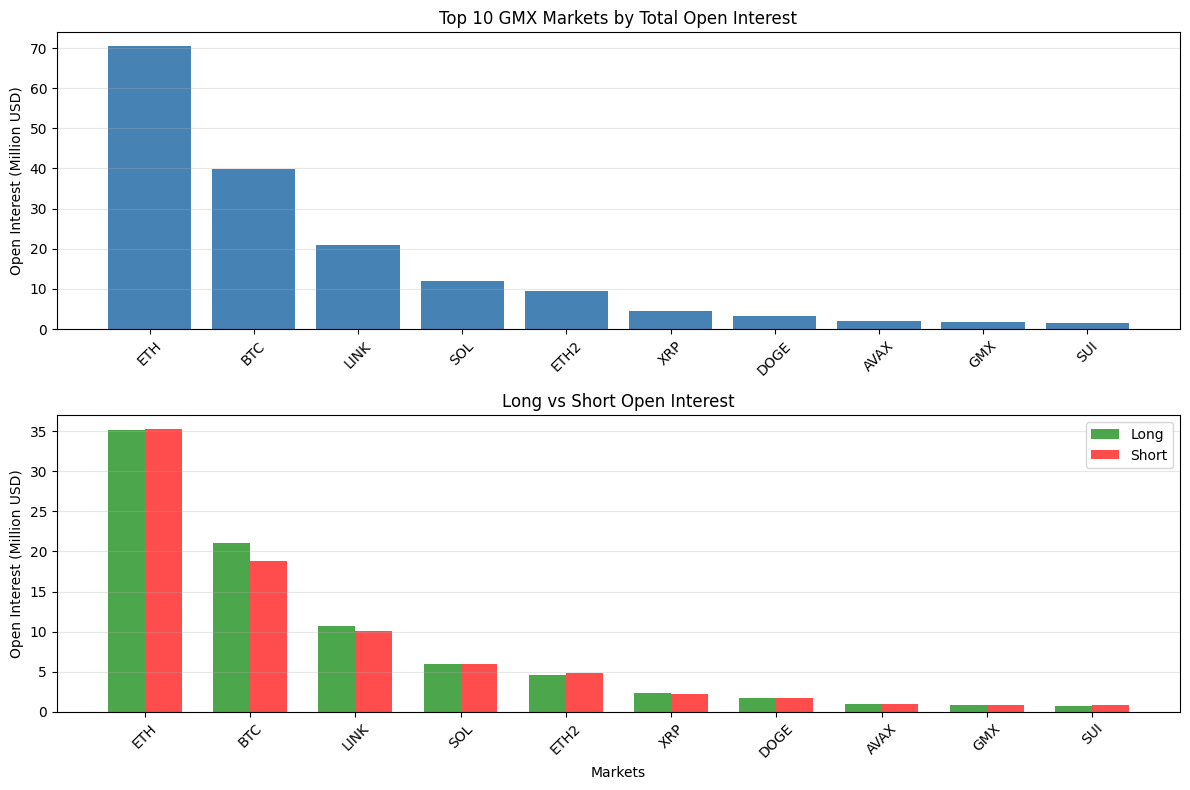

In [4]:
# Create simple bar chart of top 10 markets
top_10 = df.head(10)

plt.figure(figsize=(12, 8))

# Plot 1: Total Open Interest
plt.subplot(2, 1, 1)
plt.bar(top_10['symbol'], top_10['total_oi'] / 1e6, color='steelblue')
plt.title('Top 10 GMX Markets by Total Open Interest')
plt.ylabel('Open Interest (Million USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Long vs Short comparison
plt.subplot(2, 1, 2)
x = range(len(top_10))
width = 0.35
plt.bar([i - width/2 for i in x], top_10['long_oi'] / 1e6, width, 
        label='Long', color='green', alpha=0.7)
plt.bar([i + width/2 for i in x], top_10['short_oi'] / 1e6, width, 
        label='Short', color='red', alpha=0.7)

plt.title('Long vs Short Open Interest')
plt.ylabel('Open Interest (Million USD)')
plt.xlabel('Markets')
plt.xticks(x, top_10['symbol'], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()